In [37]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
    compress_repeated_epochs
)
from ripple_heterogeneity.assembly import assembly_reactivation,find_sig_assembly
from ripple_heterogeneity.readout import assembly_multi_region, assembly_strength_gradual_formation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
from matplotlib.ticker import AutoMinorLocator
import os
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
import nelpy.plotting as npl
import seaborn.objects as so
from statsmodels.stats.proportion import proportions_ztest


functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [3]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA10\day12
1,Z:\Data\AYAold\AYA7\day19
2,Z:\Data\AYAold\AYA7\day20
3,Z:\Data\AYAold\AYA7\day24
4,Z:\Data\AYAold\AYA7\day25
...,...
114,Z:\Data\Kenji\i01_maze15_MS.001_004
115,Z:\Data\Kenji\nlx_070329
116,Z:\Data\ORproject\OR18\day1
117,Z:\Data\ORproject\OR18\day2


In [52]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_strength_gradual_formation_v2"

batch_analysis.run(
    df_sessions,
    save_path,
    assembly_strength_gradual_formation.run,
    parallel=False,
    skip_if_error=False,
    verbose=False,
)
label_df = assembly_strength_gradual_formation.load_results(save_path)

100%|██████████| 119/119 [00:00<00:00, 764.86it/s]


Loading results...


In [59]:
label_df = assembly_strength_gradual_formation.load_results(save_path)
label_df.loc[label_df.cross_region_label=="Deep_EC1|EC2|EC3|EC4|EC5|MEC","cross_region_label"] = "deep_mec"
label_df.loc[label_df.cross_region_label=="Superficial_EC1|EC2|EC3|EC4|EC5|MEC","cross_region_label"] = "sup_mec"
label_df.loc[label_df.cross_region_label=="Deep_PFC","cross_region_label"] = "deep_pfc"
label_df.loc[label_df.cross_region_label=="Superficial_PFC","cross_region_label"] = "sup_pfc"
label_df["constant"] = 1

Loading results...


In [54]:
label_df

,assembly_n,slopes,pvals,cross_region_label,basepath,contant
0,0,0.000942,0.115768,deep_mec,Z:\Data\AYAold\AYA10\day12,1
1,1,-0.002255,0.001996,deep_mec,Z:\Data\AYAold\AYA10\day12,1
2,2,0.000057,0.962076,deep_mec,Z:\Data\AYAold\AYA10\day12,1
3,3,0.001855,0.003992,deep_mec,Z:\Data\AYAold\AYA10\day12,1
4,4,-0.000495,0.335329,deep_mec,Z:\Data\AYAold\AYA10\day12,1
...,...,...,...,...,...,...
1434,12,0.000667,0.063872,sup_pfc,Z:\Data\ORproject\OR18\day3,1
1435,13,-0.000254,0.670659,sup_pfc,Z:\Data\ORproject\OR18\day3,1
1436,14,0.000085,0.920160,sup_pfc,Z:\Data\ORproject\OR18\day3,1
1437,15,0.001196,0.528942,sup_pfc,Z:\Data\ORproject\OR18\day3,1


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_deep_pfc vs. 1_sup_pfc: Mann-Whitney-Wilcoxon test two-sided, P_val:8.069e-01 U_stat=4.650e+02
1_deep_mec vs. 1_sup_mec: Mann-Whitney-Wilcoxon test two-sided, P_val:9.647e-01 U_stat=5.240e+02
1_sup_mec vs. 1_sup_pfc: Mann-Whitney-Wilcoxon test two-sided, P_val:4.202e-02 U_stat=2.360e+02
1_deep_mec vs. 1_deep_pfc: Mann-Whitney-Wilcoxon test two-sided, P_val:1.605e-04 U_stat=3.210e+02


(<AxesSubplot:xlabel='constant', ylabel='slopes'>,
  <statannotations.Annotation.Annotation at 0x21a08ef2f40>])

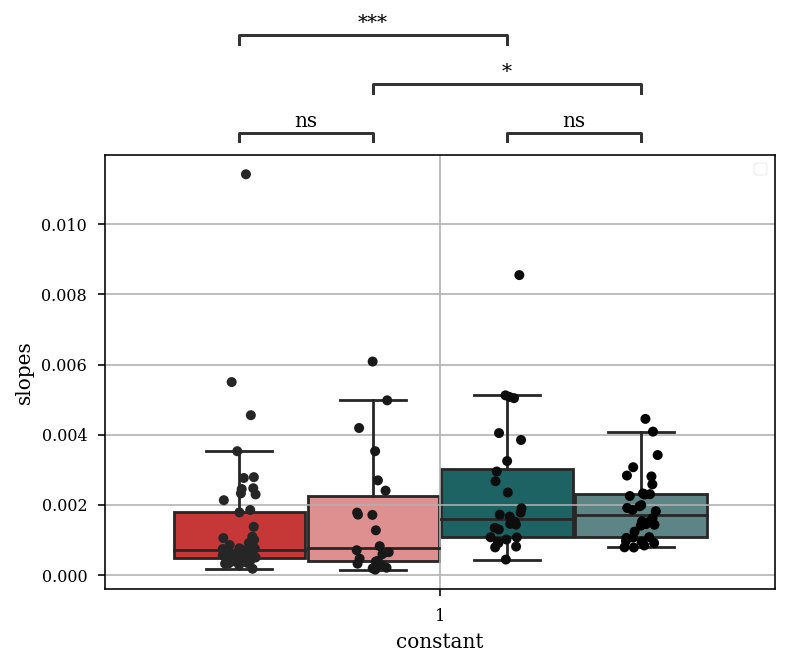

In [62]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(data=label_df.query("pvals < 0.05 & slopes>0"),x="constant", hue="cross_region_label",y="slopes",showfliers=False)
sns.stripplot(data=label_df.query("pvals < 0.05 & slopes>0"),x="constant", hue="cross_region_label",y="slopes",dodge=True,color="k")
plt.legend("")
plt.grid()

box_pairs = [
    ((1, "deep_mec"), (1, "sup_mec")),
    ((1, "deep_pfc"), (1, "sup_pfc")),
    ((1, "deep_pfc"), (1, "deep_mec")),
    ((1, "sup_pfc"), (1, "sup_mec")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=label_df.query("pvals < 0.05 & slopes>0"),
    x="constant",
    y="slopes",
    hue="cross_region_label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_mec vs. 1_pfc: Mann-Whitney-Wilcoxon test two-sided, P_val:5.220e-06 U_stat=1.124e+03


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.


(<AxesSubplot:xlabel='constant', ylabel='slopes'>,
 [<statannotations.Annotation.Annotation at 0x21a088c8610>])

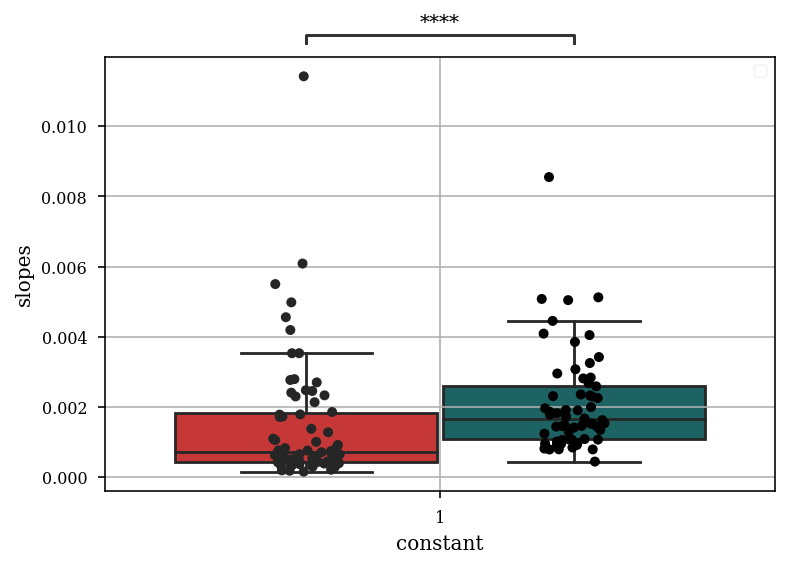

In [83]:
group_colors = {
    "mec": "#de2020",
    "pfc": "#116f70",
}
sns.set_palette(sns.color_palette(group_colors.values()))

label_df.loc[label_df.cross_region_label.str.contains("mec"),"cortex"] = "mec"
label_df.loc[label_df.cross_region_label.str.contains("pfc"),"cortex"] = "pfc"

sns.boxplot(data=label_df.query("pvals < 0.05 & slopes>0"),x="constant", hue="cortex",y="slopes",hue_order=group_colors.keys(),showfliers=False)
sns.stripplot(data=label_df.query("pvals < 0.05 & slopes>0"),x="constant", hue="cortex",y="slopes",hue_order=group_colors.keys(),dodge=True,color="k")
plt.legend("")
plt.grid()

box_pairs = [
    ((1, "mec"), (1, "pfc")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=label_df.query("pvals < 0.05 & slopes>0"),
    x="constant",
    y="slopes",
    hue="cortex",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_deep_pfc vs. 1_sup_pfc: Mann-Whitney-Wilcoxon test two-sided, P_val:3.549e-01 U_stat=1.469e+03
1_deep_mec vs. 1_sup_mec: Mann-Whitney-Wilcoxon test two-sided, P_val:9.512e-01 U_stat=1.150e+03
1_sup_mec vs. 1_sup_pfc: Mann-Whitney-Wilcoxon test two-sided, P_val:7.425e-05 U_stat=1.289e+03
1_deep_mec vs. 1_deep_pfc: Mann-Whitney-Wilcoxon test two-sided, P_val:7.393e-05 U_stat=2.555e+03


(<AxesSubplot:xlabel='constant', ylabel='slopes'>,
  <statannotations.Annotation.Annotation at 0x21a08ef2d60>])

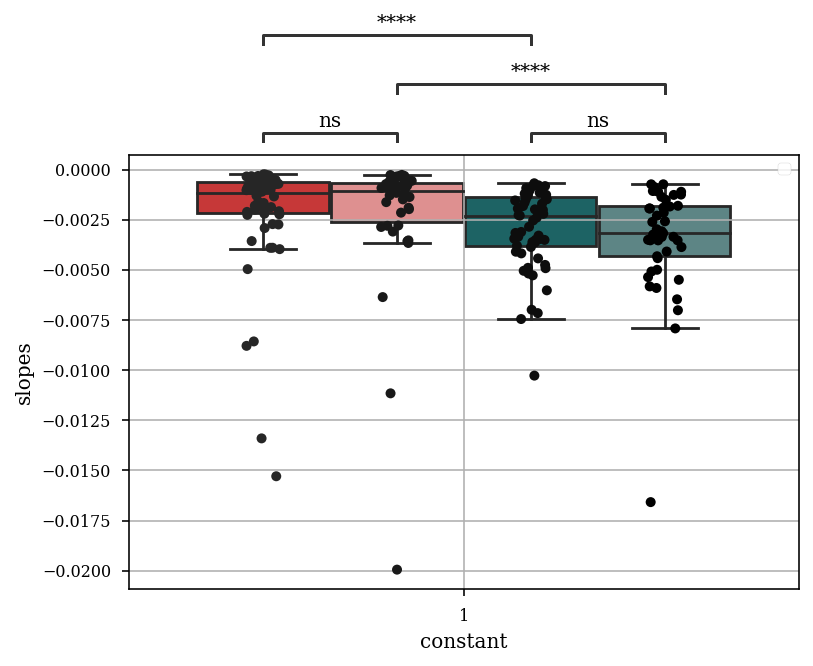

In [64]:
sns.boxplot(data=label_df.query("pvals < 0.05 & slopes<0"),x="constant", hue="cross_region_label",y="slopes",showfliers=False)
sns.stripplot(data=label_df.query("pvals < 0.05 & slopes<0"),x="constant", hue="cross_region_label",y="slopes",dodge=True,color="k")
plt.legend("")
plt.grid()

box_pairs = [
    ((1, "deep_mec"), (1, "sup_mec")),
    ((1, "deep_pfc"), (1, "sup_pfc")),
    ((1, "deep_pfc"), (1, "deep_mec")),
    ((1, "sup_pfc"), (1, "sup_mec")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=label_df.query("pvals < 0.05 & slopes<0"),
    x="constant",
    y="slopes",
    hue="cross_region_label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_mec vs. 1_pfc: Mann-Whitney-Wilcoxon test two-sided, P_val:1.441e-08 U_stat=7.520e+03


(<AxesSubplot:xlabel='constant', ylabel='slopes'>,
 [<statannotations.Annotation.Annotation at 0x21a09936df0>])

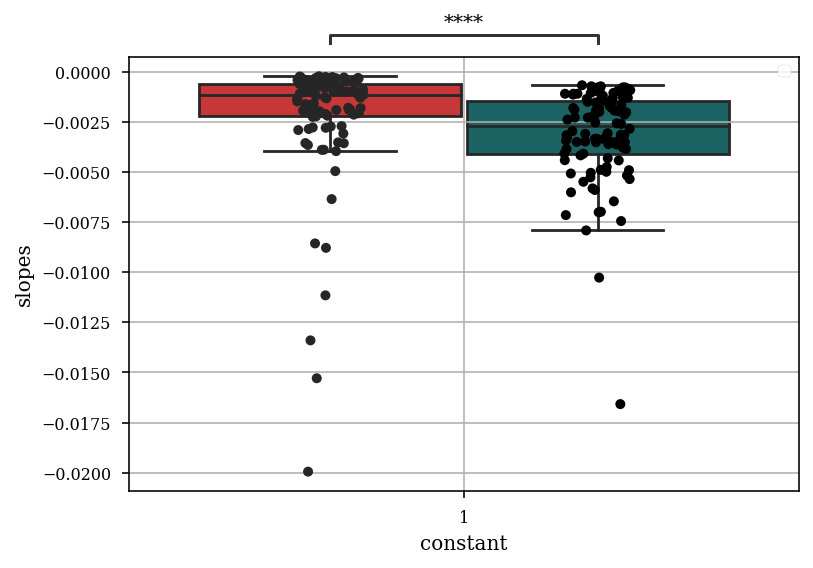

In [84]:
group_colors = {
    "mec": "#de2020",
    "pfc": "#116f70",
}
sns.set_palette(sns.color_palette(group_colors.values()))

label_df.loc[label_df.cross_region_label.str.contains("mec"),"cortex"] = "mec"
label_df.loc[label_df.cross_region_label.str.contains("pfc"),"cortex"] = "pfc"

sns.boxplot(data=label_df.query("pvals < 0.05 & slopes<0"),x="constant", hue="cortex",y="slopes",hue_order=group_colors.keys(),showfliers=False)
sns.stripplot(data=label_df.query("pvals < 0.05 & slopes<0"),x="constant", hue="cortex",y="slopes",hue_order=group_colors.keys(),dodge=True,color="k")
plt.legend("")
plt.grid()

box_pairs = [
    ((1, "mec"), (1, "pfc")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=label_df.query("pvals < 0.05 & slopes<0"),
    x="constant",
    y="slopes",
    hue="cortex",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

In [66]:
prop_slope_df = label_df.groupby("cross_region_label").apply(
    lambda x: pd.Series(
        {
            "n_pos": ((x.slopes > 0) & (x.pvals < 0.05)).sum(),
            "n_neg": ((x.slopes < 0) & (x.pvals < 0.05)).sum(),
            "n_total": len(x.slopes),
        }
    )
).reset_index()

prop_slope_df["prop_pos"] = prop_slope_df.n_pos / prop_slope_df.n_total
prop_slope_df["prop_neg"] = prop_slope_df.n_neg / prop_slope_df.n_total
prop_slope_df["constant"] = 1
prop_slope_df

,cross_region_label,n_pos,n_neg,n_total,prop_pos,prop_neg,constant
0,deep_mec,48,61,449,0.106904,0.135857,1
1,deep_pfc,28,59,348,0.080460,0.169540,1
2,sup_mec,22,38,316,0.069620,0.120253,1
3,sup_pfc,32,45,326,0.098160,0.138037,1


Text(0.5, 0, '')

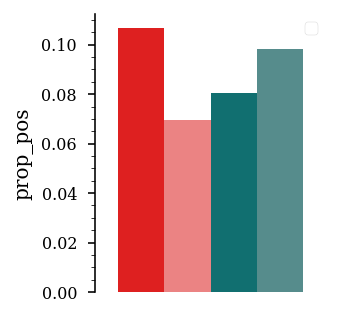

In [67]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.35, subplots=(2, 1)), edgecolor=None
)
sns.barplot(data=prop_slope_df,x="constant",y="prop_pos",hue="cross_region_label",hue_order=group_colors.keys(),saturation=1)

sns.despine(bottom=True)
plt.legend("")
# plt.ylabel("Proportion of reward encoding")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

In [68]:
count = prop_slope_df.query("cross_region_label=='deep_mec' | cross_region_label=='sup_mec'").n_pos
nobs = prop_slope_df.query("cross_region_label=='deep_mec' | cross_region_label=='sup_mec'").n_total

stat, pval = proportions_ztest(count, nobs)
stat, pval

(1.761076636477891, 0.07822543280691079)

In [69]:
count = prop_slope_df.query("cross_region_label=='deep_pfc' | cross_region_label=='sup_pfc'").n_pos
nobs = prop_slope_df.query("cross_region_label=='deep_pfc' | cross_region_label=='sup_pfc'").n_total

stat, pval = proportions_ztest(count, nobs)
stat, pval

(-0.8063719717791145, 0.42002840293847943)

Text(0.5, 0, '')

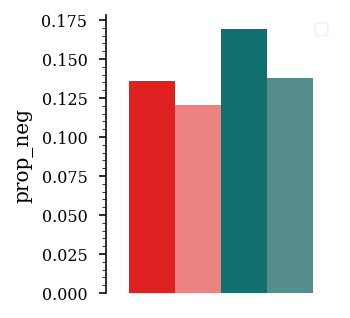

In [70]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.35, subplots=(2, 1)), edgecolor=None
)
sns.barplot(data=prop_slope_df,x="constant",y="prop_neg",hue="cross_region_label",hue_order=group_colors.keys(),saturation=1)

sns.despine(bottom=True)
plt.legend("")
# plt.ylabel("Proportion of reward encoding")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

In [71]:
count = prop_slope_df.query("cross_region_label=='deep_mec' | cross_region_label=='sup_mec'").prop_neg
nobs = prop_slope_df.query("cross_region_label=='deep_mec' | cross_region_label=='sup_mec'").n_total

stat, pval = proportions_ztest(count, nobs)
stat, pval

(-0.05804353485408591, 0.9537139511606697)

In [72]:
count = prop_slope_df.query("cross_region_label=='deep_pfc' | cross_region_label=='sup_pfc'").prop_neg
nobs = prop_slope_df.query("cross_region_label=='deep_pfc' | cross_region_label=='sup_pfc'").n_total

stat, pval = proportions_ztest(count, nobs)
stat, pval

(0.038731161759081034, 0.9691047285511878)

## testing below

In [34]:
def get_cross_region_assemblies(
    basepath,
    regions=None,  # brain regions to load
    deepSuperficial=None,
    putativeCellType="Pyr",  # type of cells to load (can be multi ex. Pyr|Int)
    weight_dt=0.05,  # dt in seconds for binning st to get weights for each assembly
    z_mat_dt=60,
):
    m1 = assembly_reactivation.AssemblyReact(
        basepath,
        brainRegion=regions,
        putativeCellType=putativeCellType,
        weight_dt=weight_dt,
        z_mat_dt=z_mat_dt,
    )
    st, cell_metrics = loading.load_spikes(
        basepath,
        brainRegion=regions,
        putativeCellType=putativeCellType,
    )
    cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)
    m1.st = st.iloc[:,cell_metrics.deepSuperficial.str.contains(deepSuperficial+"|unknown").values]
    m1.cell_metrics = cell_metrics[cell_metrics.deepSuperficial.str.contains(deepSuperficial+"|unknown").values]

    m1.load_epoch()

    m1.get_weights(epoch=m1.epochs[1])
    assembly_act = m1.get_assembly_act()
    return m1, assembly_act

m1_deep_pfc, assembly_act_deep_pfc = get_cross_region_assemblies(basepath,regions="CA1|PFC",deepSuperficial="Deep")
m1_sup_pfc, assembly_act_sup_pfc = get_cross_region_assemblies(basepath,regions="CA1|PFC",deepSuperficial="Superficial")
m1_deep_mec, assembly_act_deep_mec = get_cross_region_assemblies(basepath,regions="CA1|EC1|EC2|EC3|EC4|EC5|MEC",deepSuperficial="Deep")
m1_sup_mec, assembly_act_sup_mec = get_cross_region_assemblies(basepath,regions="CA1|EC1|EC2|EC3|EC4|EC5|MEC",deepSuperficial="Superficial")


In [98]:
# nel.analogsignalArray(data=assembly_act_sup_pfc.data)
assembly_act = nel.AnalogSignalArray(
    data=np.vstack(
        [
            assembly_act_deep_pfc.data,
            assembly_act_sup_pfc.data,
            assembly_act_deep_mec.data,
            assembly_act_sup_mec.data,
        ]
    ),
    timestamps=assembly_act_deep_pfc.abscissa_vals
)
assembly_act

<AnalogSignalArray at 0x1d14c27fb50: 84 signals> for a total of 6:36:00 hours

In [35]:
assembly_act_deep_pfc,assembly_act_sup_pfc,assembly_act_deep_mec,assembly_act_sup_mec

(<AnalogSignalArray at 0x1d14c2376d0: 28 signals> for a total of 6:36:00 hours,
 <AnalogSignalArray at 0x1d14ac3ebe0: 26 signals> for a total of 6:36:00 hours,
 <AnalogSignalArray at 0x1d160f8a910: 16 signals> for a total of 6:36:00 hours,
 <AnalogSignalArray at 0x1d1abcfc6d0: 14 signals> for a total of 6:36:00 hours)

In [86]:
# prop_df, assembly_df, keep_assembly = assembly_multi_region.compile_results_df({"react":m1})
# # assembly_act._data = assembly_act.data[keep_assembly]

# assembly_df

In [50]:
from sklearn.linear_model import LinearRegression
def find_slope_over_time(assembly_act,epoch):
    X = assembly_act[epoch].abscissa_vals.reshape(-1, 1)
    y = assembly_act[epoch].data.T
    reg = LinearRegression().fit(X, y)
    return reg.coef_.flatten()

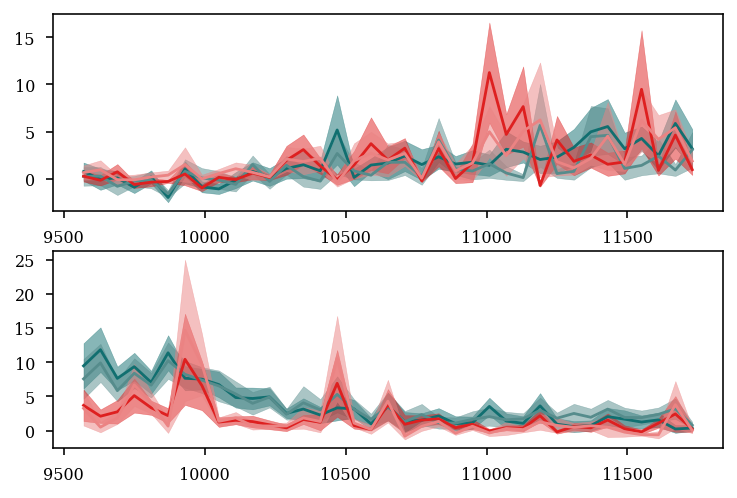

In [72]:
import logging
logging.getLogger().setLevel(logging.ERROR)

def plot_assembly_shadded_error(assembly_act,epoch,color="k",ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(assembly_act[epoch].abscissa_vals, assembly_act[epoch].mean(axis=0),color=color)
    y = assembly_act[epoch].mean(axis=0)
    error = assembly_act[epoch].std(axis=0) / np.sqrt(assembly_act.n_signals)
    ax.fill_between(assembly_act[epoch].abscissa_vals, y-error, y+error, zorder=-1000, color=color,alpha=.5)

group_colors = {
    "Deep MEC": "#de2020",
    "Superficial MEC": "#eb8383",
    "Deep PFC": "#116f70",
    "Superficial PFC": "#568c8c",
}
fig,ax = plt.subplots(2,1)

idx = find_slope_over_time(assembly_act_deep_pfc,m1_deep_pfc.epochs[1]) > 0
plot_assembly_shadded_error(assembly_act_deep_pfc[:,idx],m1_deep_pfc.epochs[1],color=group_colors["Deep PFC"],ax=ax[0])
idx = find_slope_over_time(assembly_act_sup_pfc,m1_deep_pfc.epochs[1]) > 0
plot_assembly_shadded_error(assembly_act_sup_pfc[:,idx],m1_deep_pfc.epochs[1],color=group_colors["Superficial PFC"],ax=ax[0])
idx = find_slope_over_time(assembly_act_deep_mec,m1_deep_pfc.epochs[1]) > 0
plot_assembly_shadded_error(assembly_act_deep_mec[:,idx],m1_deep_pfc.epochs[1],color=group_colors["Deep MEC"],ax=ax[0])
idx = find_slope_over_time(assembly_act_sup_mec,m1_deep_pfc.epochs[1]) > 0
plot_assembly_shadded_error(assembly_act_sup_mec[:,idx],m1_deep_pfc.epochs[1],color=group_colors["Superficial MEC"],ax=ax[0])

idx = find_slope_over_time(assembly_act_deep_pfc,m1_deep_pfc.epochs[1]) < 0
plot_assembly_shadded_error(assembly_act_deep_pfc[:,idx],m1_deep_pfc.epochs[1],color=group_colors["Deep PFC"],ax=ax[1])
idx = find_slope_over_time(assembly_act_sup_pfc,m1_deep_pfc.epochs[1]) < 0
plot_assembly_shadded_error(assembly_act_sup_pfc[:,idx],m1_deep_pfc.epochs[1],color=group_colors["Superficial PFC"],ax=ax[1])
idx = find_slope_over_time(assembly_act_deep_mec,m1_deep_pfc.epochs[1]) < 0
plot_assembly_shadded_error(assembly_act_deep_mec[:,idx],m1_deep_pfc.epochs[1],color=group_colors["Deep MEC"],ax=ax[1])
idx = find_slope_over_time(assembly_act_sup_mec,m1_deep_pfc.epochs[1]) < 0
plot_assembly_shadded_error(assembly_act_sup_mec[:,idx],m1_deep_pfc.epochs[1],color=group_colors["Superficial MEC"],ax=ax[1])


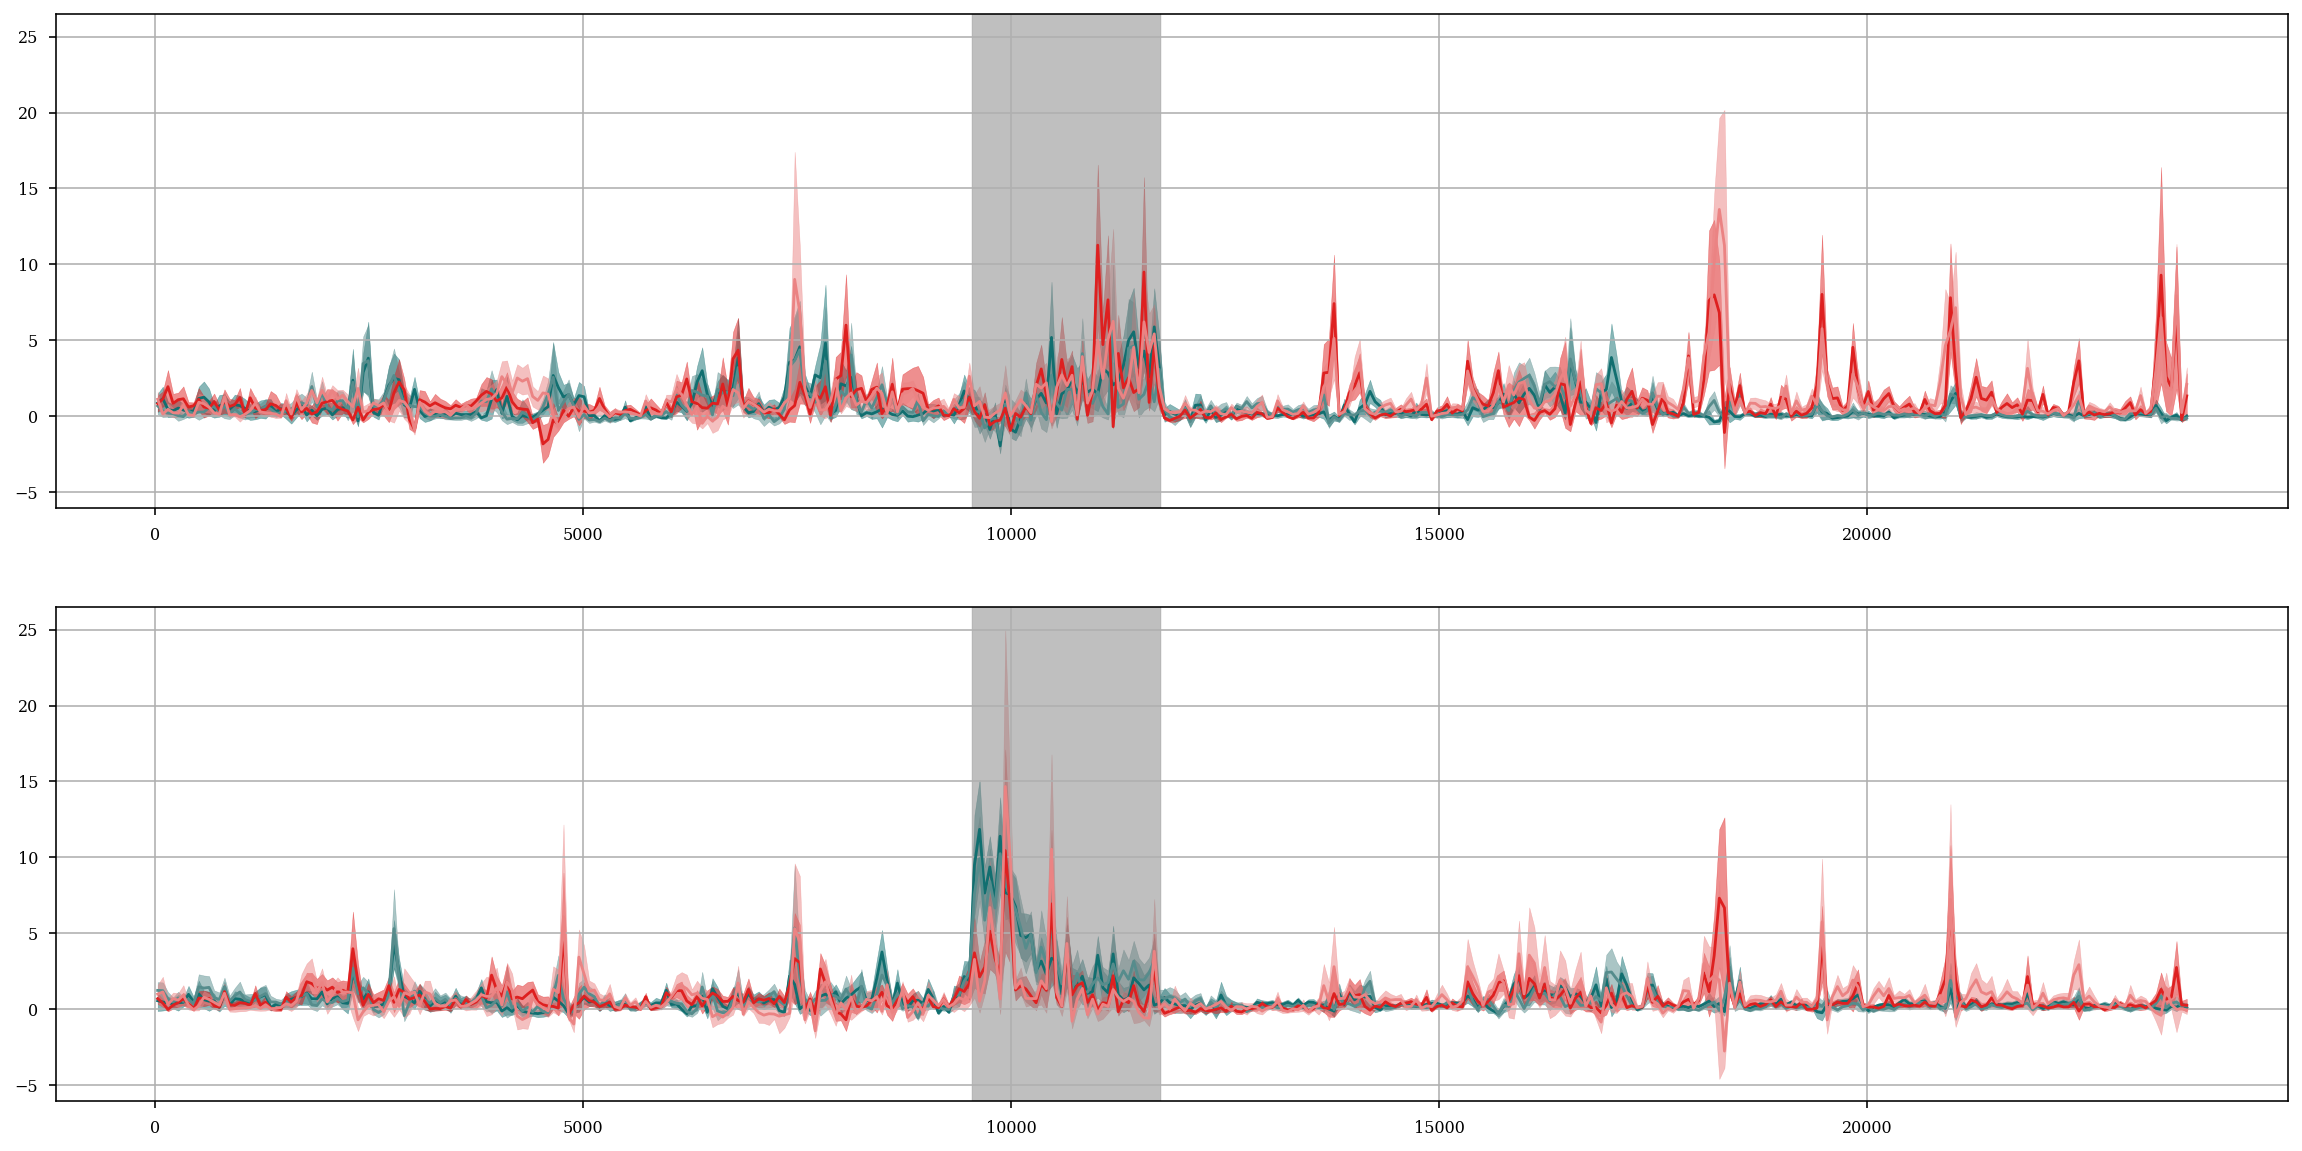

In [85]:
fig,ax = plt.subplots(2,1,figsize=(20,10),sharey=True)
epoch = assembly_act_deep_pfc.support

idx = find_slope_over_time(assembly_act_deep_pfc,m1_deep_pfc.epochs[1]) > 0
plot_assembly_shadded_error(assembly_act_deep_pfc[:,idx],epoch,color=group_colors["Deep PFC"],ax=ax[0])
idx = find_slope_over_time(assembly_act_sup_pfc,m1_deep_pfc.epochs[1]) > 0
plot_assembly_shadded_error(assembly_act_sup_pfc[:,idx],epoch,color=group_colors["Superficial PFC"],ax=ax[0])
idx = find_slope_over_time(assembly_act_deep_mec,m1_deep_pfc.epochs[1]) > 0
plot_assembly_shadded_error(assembly_act_deep_mec[:,idx],epoch,color=group_colors["Deep MEC"],ax=ax[0])
idx = find_slope_over_time(assembly_act_sup_mec,m1_deep_pfc.epochs[1]) > 0
plot_assembly_shadded_error(assembly_act_sup_mec[:,idx],epoch,color=group_colors["Superficial MEC"],ax=ax[0])

idx = find_slope_over_time(assembly_act_deep_pfc,m1_deep_pfc.epochs[1]) < 0
plot_assembly_shadded_error(assembly_act_deep_pfc[:,idx],epoch,color=group_colors["Deep PFC"],ax=ax[1])
idx = find_slope_over_time(assembly_act_sup_pfc,m1_deep_pfc.epochs[1]) < 0
plot_assembly_shadded_error(assembly_act_sup_pfc[:,idx],epoch,color=group_colors["Superficial PFC"],ax=ax[1])
idx = find_slope_over_time(assembly_act_deep_mec,m1_deep_pfc.epochs[1]) < 0
plot_assembly_shadded_error(assembly_act_deep_mec[:,idx],epoch,color=group_colors["Deep MEC"],ax=ax[1])
idx = find_slope_over_time(assembly_act_sup_mec,m1_deep_pfc.epochs[1]) < 0
plot_assembly_shadded_error(assembly_act_sup_mec[:,idx],epoch,color=group_colors["Superficial MEC"],ax=ax[1])

npl.epochplot(m1_deep_pfc.epochs[1],ax=ax[0])
npl.epochplot(m1_deep_pfc.epochs[1],ax=ax[1])

ax[0].grid()
ax[1].grid()

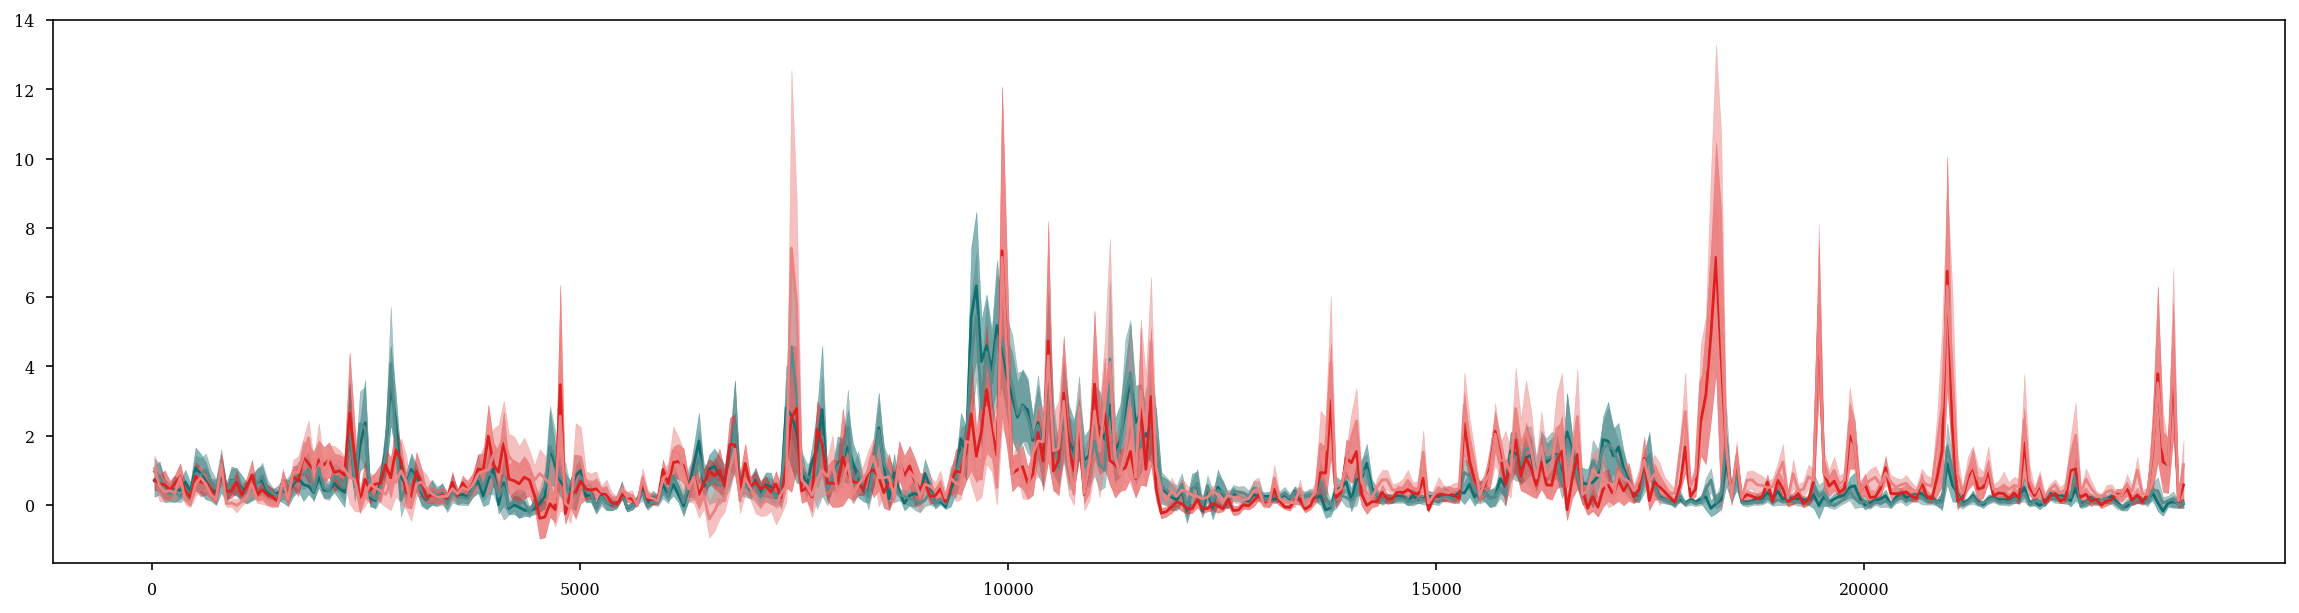

In [37]:
plt.figure(figsize=(20,5))

epoch = assembly_act_deep_pfc.support
plot_assembly_shadded_error(assembly_act_deep_pfc,epoch,color=group_colors["Deep PFC"])
plot_assembly_shadded_error(assembly_act_sup_pfc,epoch,color=group_colors["Superficial PFC"])

plot_assembly_shadded_error(assembly_act_deep_mec,epoch,color=group_colors["Deep MEC"])
plot_assembly_shadded_error(assembly_act_sup_mec,epoch,color=group_colors["Superficial MEC"])


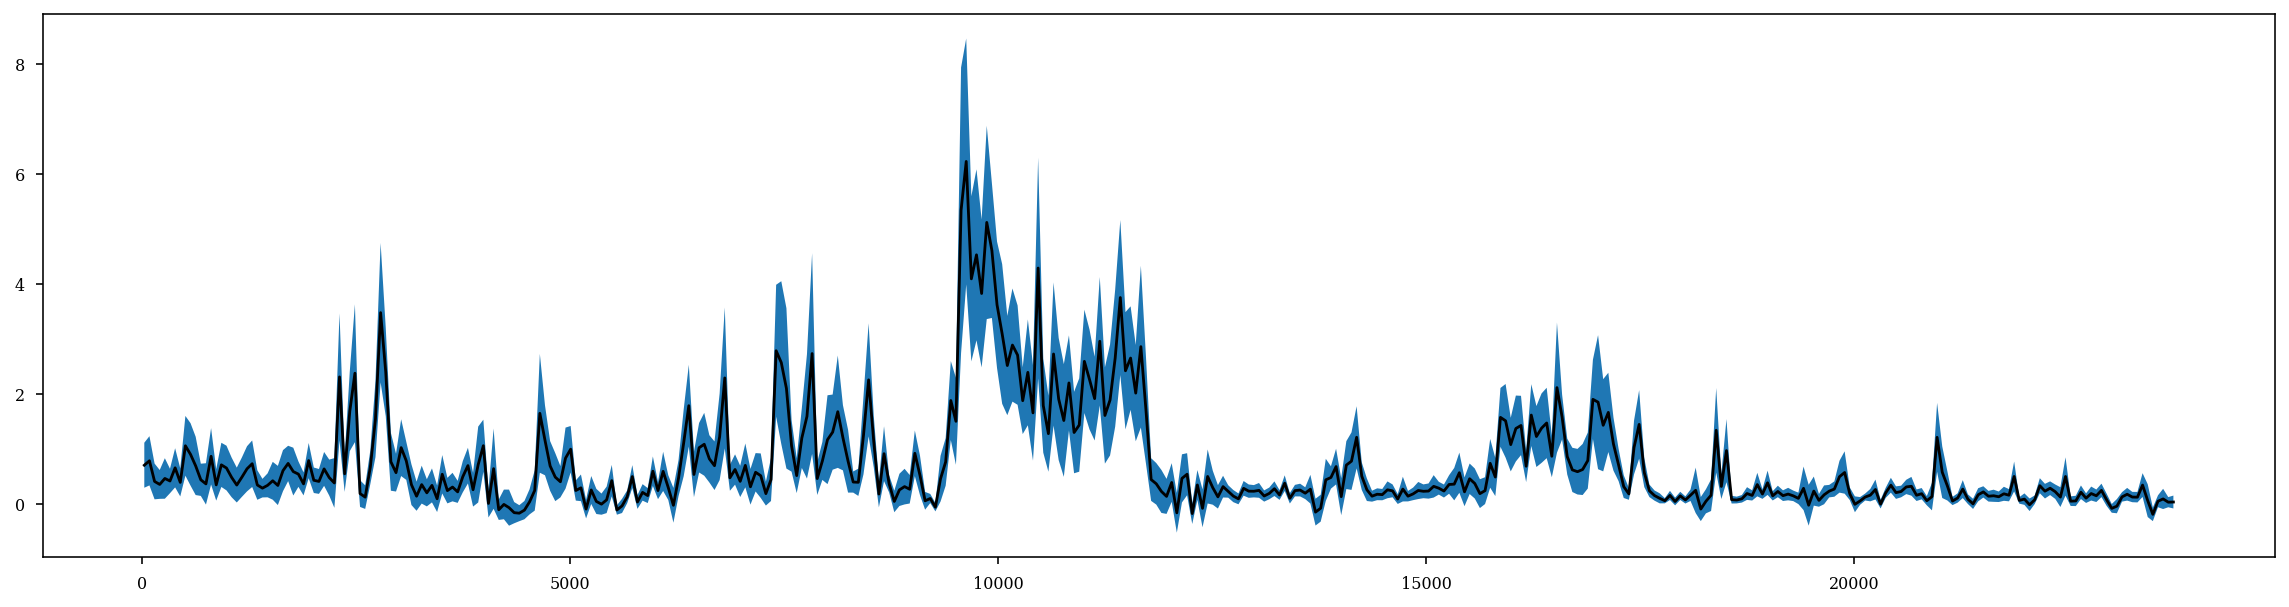

In [22]:
plt.figure(figsize=(20,5))
plt.plot(assembly_act_deep_pfc.abscissa_vals, assembly_act_deep_pfc.mean(axis=0),color="k")
y = assembly_act_deep_pfc.mean(axis=0)
error = assembly_act_deep_pfc.std(axis=0) / np.sqrt(assembly_act_deep_pfc.n_signals)
plt.fill_between(assembly_act_deep_pfc.abscissa_vals, y-error, y+error, zorder=-1000)

plt.show()

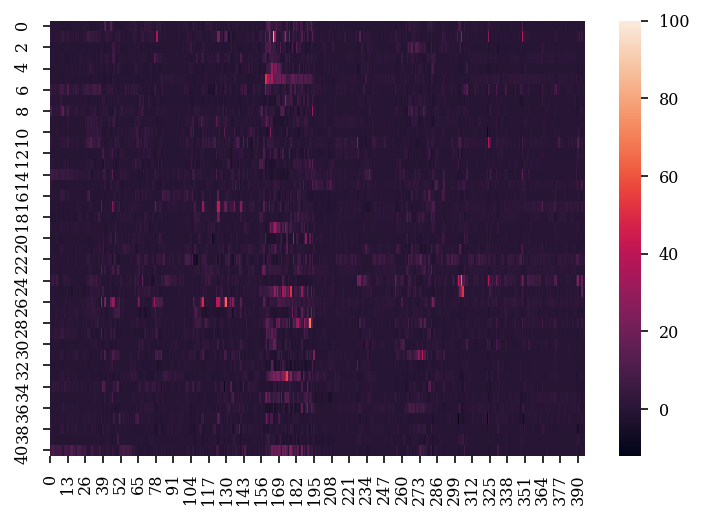

In [30]:
sns.heatmap(assembly_act.data,vmax=100)
plt.show()

In [ ]:
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt")

# batch_analysis.run(
#     sessions,
#     save_path,
#     assembly_multi_region.run,
#     parallel=True,
#     overwrite=False,
#     verbose=True,
#     skip_if_error=False,
#     weight_dt=.05,
#     z_mat_dt=0.01
# )
# # load results
# prop_df, assembly_df, df_strength = assembly_multi_region.load_results(save_path)